## Decision Tree Classification on Amazon Reviews Dataset
#### Rishiraj Adhikary | corvinelabs.com

### Objective
    - Convert text to vectors using, BoW, TFIDF, AVG-W2V, TFIDF-wt-W2v
    - Classifify reviews as positive or negative on all these vectors
    - Show necessary evaluation measures of model

In [1]:
#load necessary packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Load the Amazon Fine Food review data

# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


### Removing Duplicate Entries In Data

In [2]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

(4986, 10)


99.72

In [3]:
#For a given data point, HelpfulnessNumerator can never be greater then HelpfulnessDenominator. Hence filtering
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

### Preprocessing of Text Data
Involves multiple steps. Documentation Pending

In [4]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html5lib').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:03<00:00, 1419.95it/s]


In [5]:
#Helper function to print heatmap from confusionmatrix. Used Later 
#Source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

### Applying Decision Tree on Bag of Word Vector Representation of Text

/home/rishiraj/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out training text BOW vectorizer  (3490, 10976)
The number of unique words 10976
**************************************************
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out test text BOW vectorizer  (1496, 10976)
The Baseline ROC_AUC score is =  0.6222238908972585
Optimal Depth for Train Data =  49.0
Optimal Depth for Test Data =  48.0


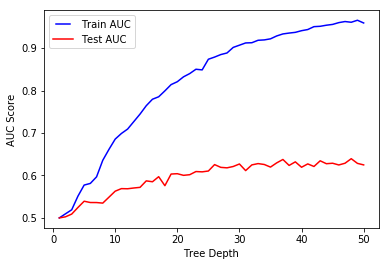

Optimal Minimum Sample Split for Train Data =  0.1
Optimal Minimum Sample Split for Test Data =  0.1


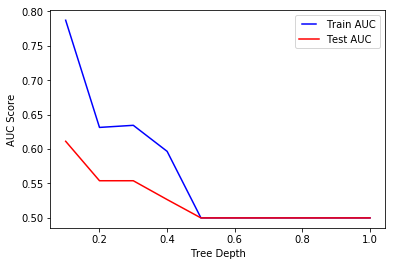

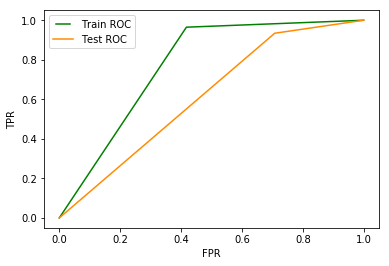

The AUC Score of test data =  0.6132291364964261


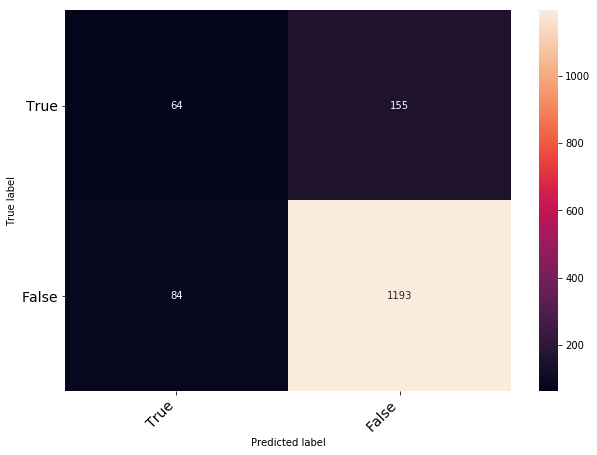

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import graphviz
from sklearn import tree
from matplotlib.legend_handler import HandlerLine2D
#Train Test Split Before Vectorizing. This is to prevent Data Leakage
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

#BoW On Training Data
count_vect = CountVectorizer() 
final_counts_train = count_vect.fit_transform(X_train)
#BOW Data Features
bow_features = count_vect.get_feature_names()

#Print Some stats
print("The type of count vectorizer ",type(final_counts_train))
print("The shape of out training text BOW vectorizer ",final_counts_train.get_shape())
print("The number of unique words", final_counts_train.get_shape()[1])
print('*'*50)

#BoW On Test Data
final_counts_test = count_vect.transform(X_test)
print("The type of count vectorizer ",type(final_counts_test))
print("The shape of out test text BOW vectorizer ",final_counts_test.get_shape())





clf = tree.DecisionTreeClassifier()
clf = clf.fit(final_counts_train, y_train)
y_pred = clf.predict(final_counts_test)

#Baseline Performance ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The Baseline ROC_AUC score is = ",roc_auc)


#Finding Optimal Depth 


max_depths = np.linspace(1, 50, 50, endpoint=True)
train_results = []
test_results = []

#stores the optimum depth which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalDepthTrain = 0
optimalDepthTest = 0

for max_depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(final_counts_train, y_train)
    train_pred = clf.predict(final_counts_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalDepthTrain = max_depth
    # Add auc score to previous train results
    train_results.append(roc_auc_train)

    y_pred = clf.predict(final_counts_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalDepthTest = max_depth
    # Add auc score to previous test results
    test_results.append(roc_auc_test)
    
    

print("Optimal Depth for Train Data = ",optimalDepthTrain)
print("Optimal Depth for Test Data = ",optimalDepthTest)

line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()

#Finding the min_samples_split

from matplotlib.legend_handler import HandlerLine2D
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

#stores the optimum minSamples Split which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalMinSSplitTrain = 0
optimalMinSSplitTest = 0

for min_samples_split in min_samples_splits:
    clf = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
    clf.fit(final_counts_train, y_train)
    train_pred = clf.predict(final_counts_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalMinSSplitTrain = min_samples_split
        
    # Add auc score to previous train results
    train_results.append(roc_auc_train)
    
    y_pred = clf.predict(final_counts_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalMinSSplitTest = min_samples_split
    # Add auc score to previous test results
    test_results.append(roc_auc_test)

print("Optimal Minimum Sample Split for Train Data = ",optimalMinSSplitTrain)
print("Optimal Minimum Sample Split for Test Data = ",optimalMinSSplitTest)

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()


#Finding Model Performance based on optimal parameters found above. We will plot the ROC and show the confusion matrix

#Training with optimal parameters
clff = tree.DecisionTreeClassifier(max_depth=41, min_samples_split=0.1)
clff = clff.fit(final_counts_train, y_train)
#Prediction on train and test data
train_pred = clff.predict(final_counts_train)
y_pred = clff.predict(final_counts_test)


#ROC for training data
false_positive_rateTr, true_positive_rateTr, thresholdsTr = roc_curve(y_train, train_pred)
#ROC for test data
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Plot ROC for train/test
line1, = plt.plot(false_positive_rateTr, true_positive_rateTr, 'green', label="Train ROC")
line2, = plt.plot(false_positive_rate, true_positive_rate, 'darkorange', label="Test ROC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data = ",roc_auc)

cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']

print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

### Top 20 Features From Bag of Word

In [9]:
dictSet1 = dict(zip(bow_features, clff.feature_importances_))
dictSet1RSorted = sorted(dictSet1.items(), key=lambda kv: kv[1], reverse=True)
print(dictSet1RSorted[0:20])

[('not', 0.12053891759466281), ('great', 0.04864826135452426), ('disappointed', 0.04446742604985644), ('love', 0.03224827695760745), ('awful', 0.026732607394616054), ('waste', 0.026382867862864725), ('disappointing', 0.02463500651971773), ('best', 0.02382264846841722), ('item', 0.023582422123939035), ('good', 0.022723883659734833), ('received', 0.01607312342253391), ('mushy', 0.015459934746676974), ('nice', 0.015052556284475058), ('ingredient', 0.015017709811564047), ('rather', 0.014346960110853891), ('worst', 0.013784179265066115), ('threw', 0.013073038714673134), ('delicious', 0.01264476264999285), ('says', 0.012446931484751523), ('sugar', 0.012363249746340422)]


### Graphviz visualization of Decision Tree on BOW

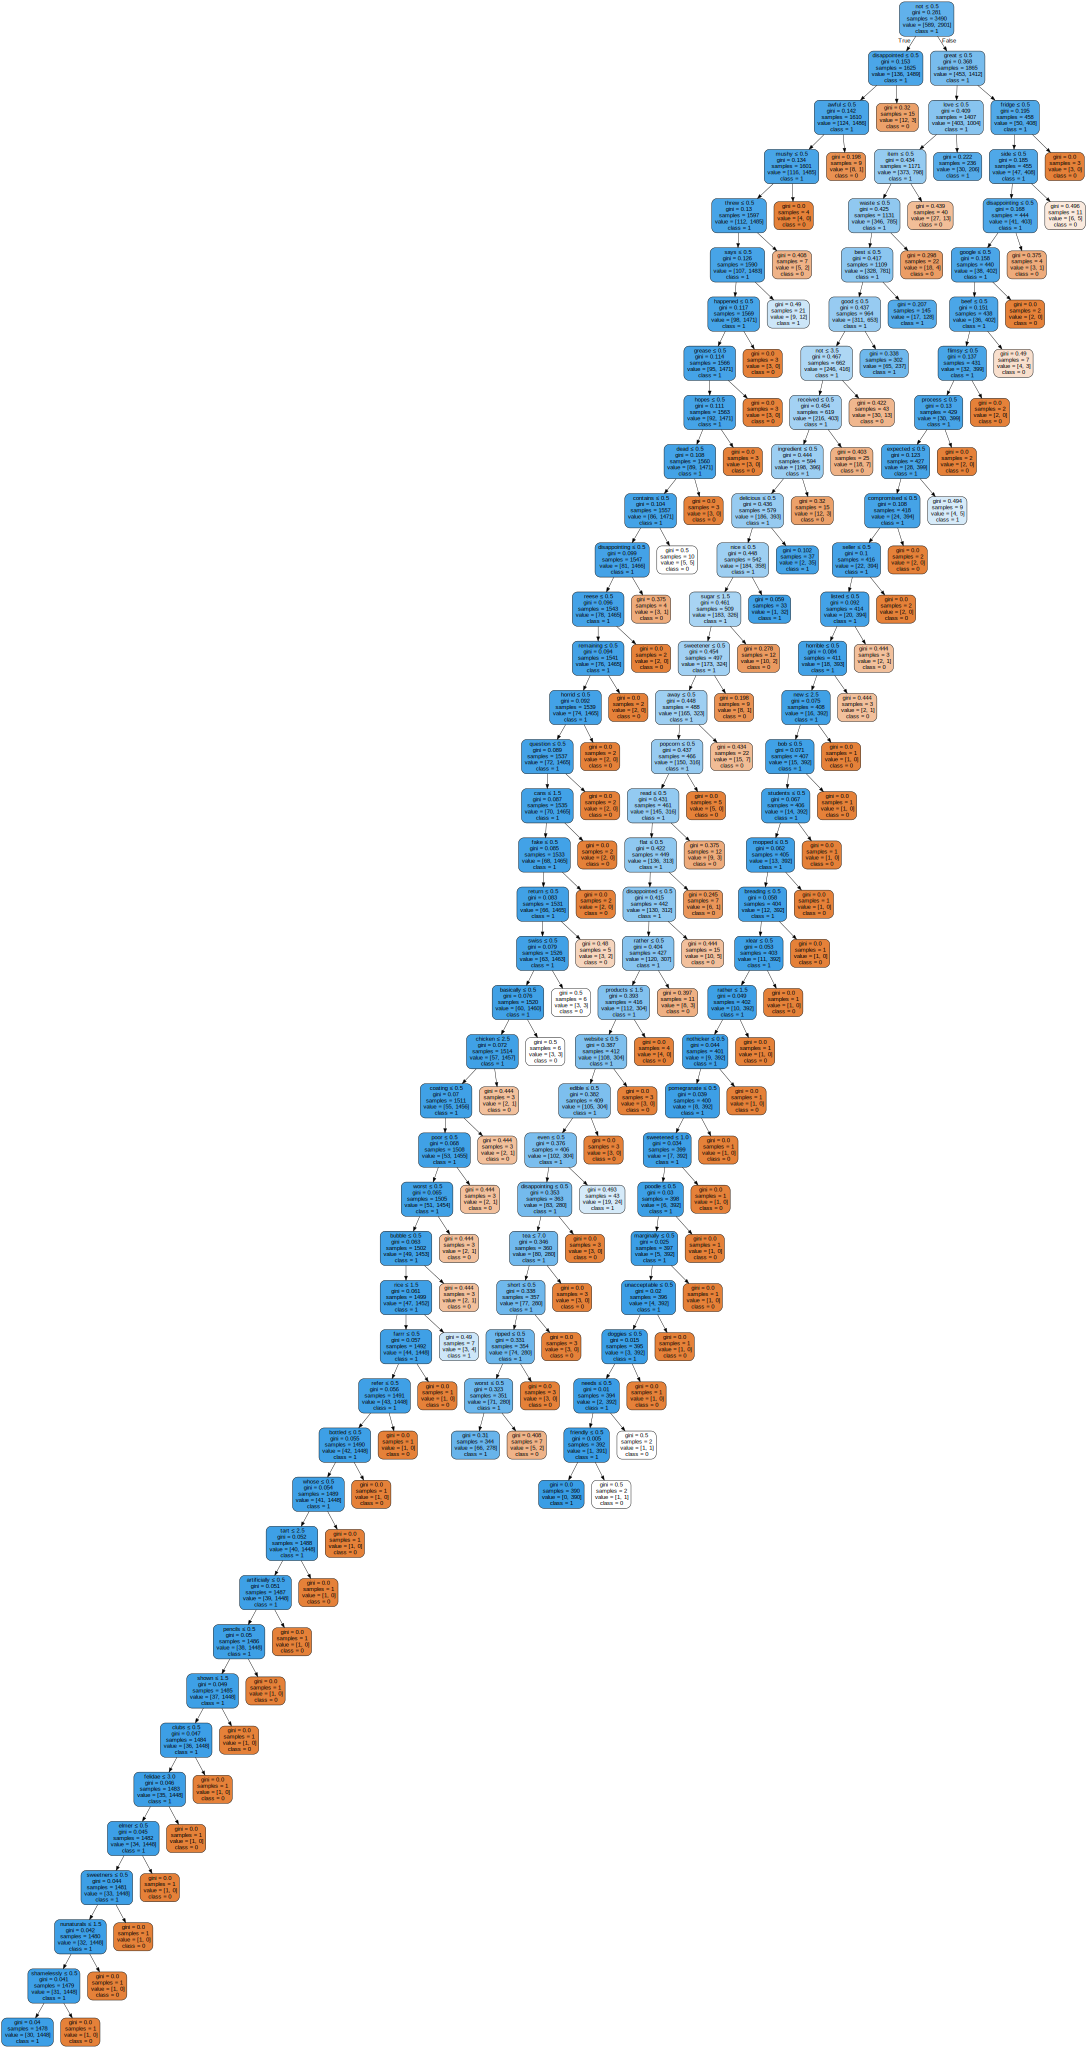

In [10]:
# Please write all the code with proper documentation
dtreeDOT = tree.export_graphviz(clff, out_file=None, feature_names=bow_features, class_names=['0','1'], filled=True, rounded=True, special_characters=True, max_depth=41)
graph = graphviz.Source(dtreeDOT) 
graph

### Applying Decision Tree on TF-IDF Vector Representation of Text

The type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of training text BOW vectorizer  (3490, 2268)
The number of unique words 2268
**************************************************
The type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out test text TFIDF vectorizer  (1496, 2268)
Optimal Depth for Train Data =  30.0
Optimal Depth for Test Data =  16.0


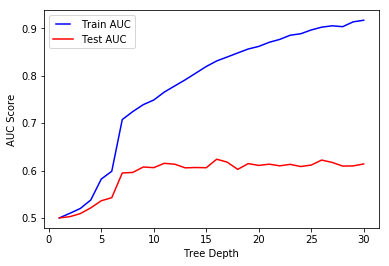

Optimal Minimum Sample Split for Train Data =  0.1
Optimal Minimum Sample Split for Test Data =  0.2


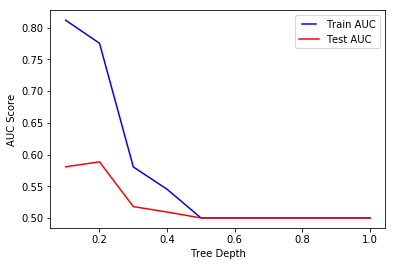

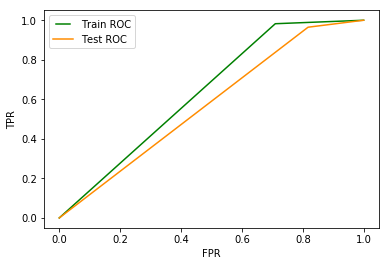

The AUC Score of test data =  0.5737047803964057


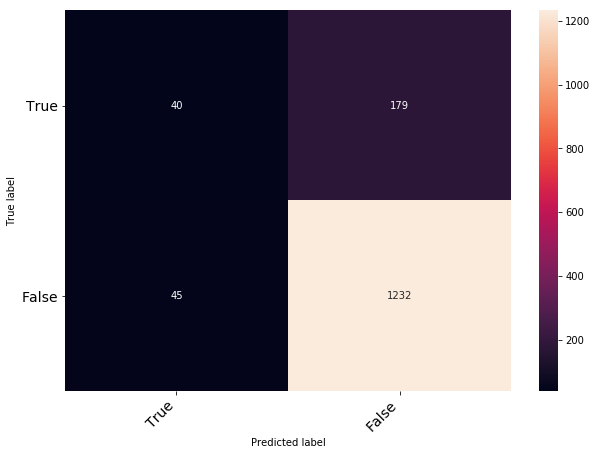

In [11]:
# Please write all the code with proper documentation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import graphviz
from sklearn import tree
from matplotlib.legend_handler import HandlerLine2D
#Train Test Split Before Vectorizing. This is to prevent Data Leakage
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

#TFIDF Vectors of Train Data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_tfidf_count_train = tf_idf_vect.fit_transform(X_train)
#TFIDF Data Features
tdidf_vect_features = tf_idf_vect.get_feature_names()
#Print Some stats
print("The type of TFIDF vectorizer ",type(final_tfidf_count_train))
print("The shape of training text BOW vectorizer ",final_tfidf_count_train.get_shape())
print("The number of unique words", final_tfidf_count_train.get_shape()[1])
print('*'*50)

#TFIDF Vectors Of Test Data
final_tfidf_count_test = tf_idf_vect.transform(X_test)
print("The type of TFIDF vectorizer ",type(final_tfidf_count_test))
print("The shape of out test text TFIDF vectorizer ",final_tfidf_count_test.get_shape())


clf2 = tree.DecisionTreeClassifier()
clf2 = clf2.fit(final_tfidf_count_train, y_train)
y_pred = clf2.predict(final_tfidf_count_test)

#Baseline Performance ROC-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
#print("The Baseline ROC_AUC score is = ",roc_auc)

#Finding Optimal Depth 

max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []

#stores the optimum depth which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalDepthTrain = 0
optimalDepthTest = 0

for max_depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(final_tfidf_count_train, y_train)
    train_pred = clf.predict(final_tfidf_count_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalDepthTrain = max_depth
    # Add auc score to previous train results
    train_results.append(roc_auc_train)

    y_pred = clf.predict(final_tfidf_count_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalDepthTest = max_depth
    # Add auc score to previous test results
    test_results.append(roc_auc_test)
    
    

print("Optimal Depth for Train Data = ",optimalDepthTrain)
print("Optimal Depth for Test Data = ",optimalDepthTest)

line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()


#Finding the min_samples_split

from matplotlib.legend_handler import HandlerLine2D
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

#stores the optimum minSamples Split which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalMinSSplitTrain = 0
optimalMinSSplitTest = 0

for min_samples_split in min_samples_splits:
    clf2 = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
    clf2.fit(final_tfidf_count_train, y_train)
    train_pred = clf2.predict(final_tfidf_count_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalMinSSplitTrain = min_samples_split
        
    # Add auc score to previous train results
    train_results.append(roc_auc_train)
    
    y_pred = clf2.predict(final_tfidf_count_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalMinSSplitTest = min_samples_split
    # Add auc score to previous test results
    test_results.append(roc_auc_test)

print("Optimal Minimum Sample Split for Train Data = ",optimalMinSSplitTrain)
print("Optimal Minimum Sample Split for Test Data = ",optimalMinSSplitTest)

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()

#Finding Model Performance based on optimal parameters found above. We will plot the ROC and show the confusion matrix

#Training with optimal parameters
clff2 = tree.DecisionTreeClassifier(max_depth=optimalDepthTest, min_samples_split=optimalMinSSplitTest)
clff2 = clff2.fit(final_tfidf_count_train, y_train)
#Prediction on train and test data
train_pred = clff2.predict(final_tfidf_count_train)
y_pred = clff2.predict(final_tfidf_count_test)


#ROC for training data
false_positive_rateTr, true_positive_rateTr, thresholdsTr = roc_curve(y_train, train_pred)
#ROC for test data
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Plot ROC for train/test
line1, = plt.plot(false_positive_rateTr, true_positive_rateTr, 'green', label="Train ROC")
line2, = plt.plot(false_positive_rate, true_positive_rate, 'darkorange', label="Test ROC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data = ",roc_auc)

cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']

print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

### Graphviz visualization of Decision Tree on TFIDF


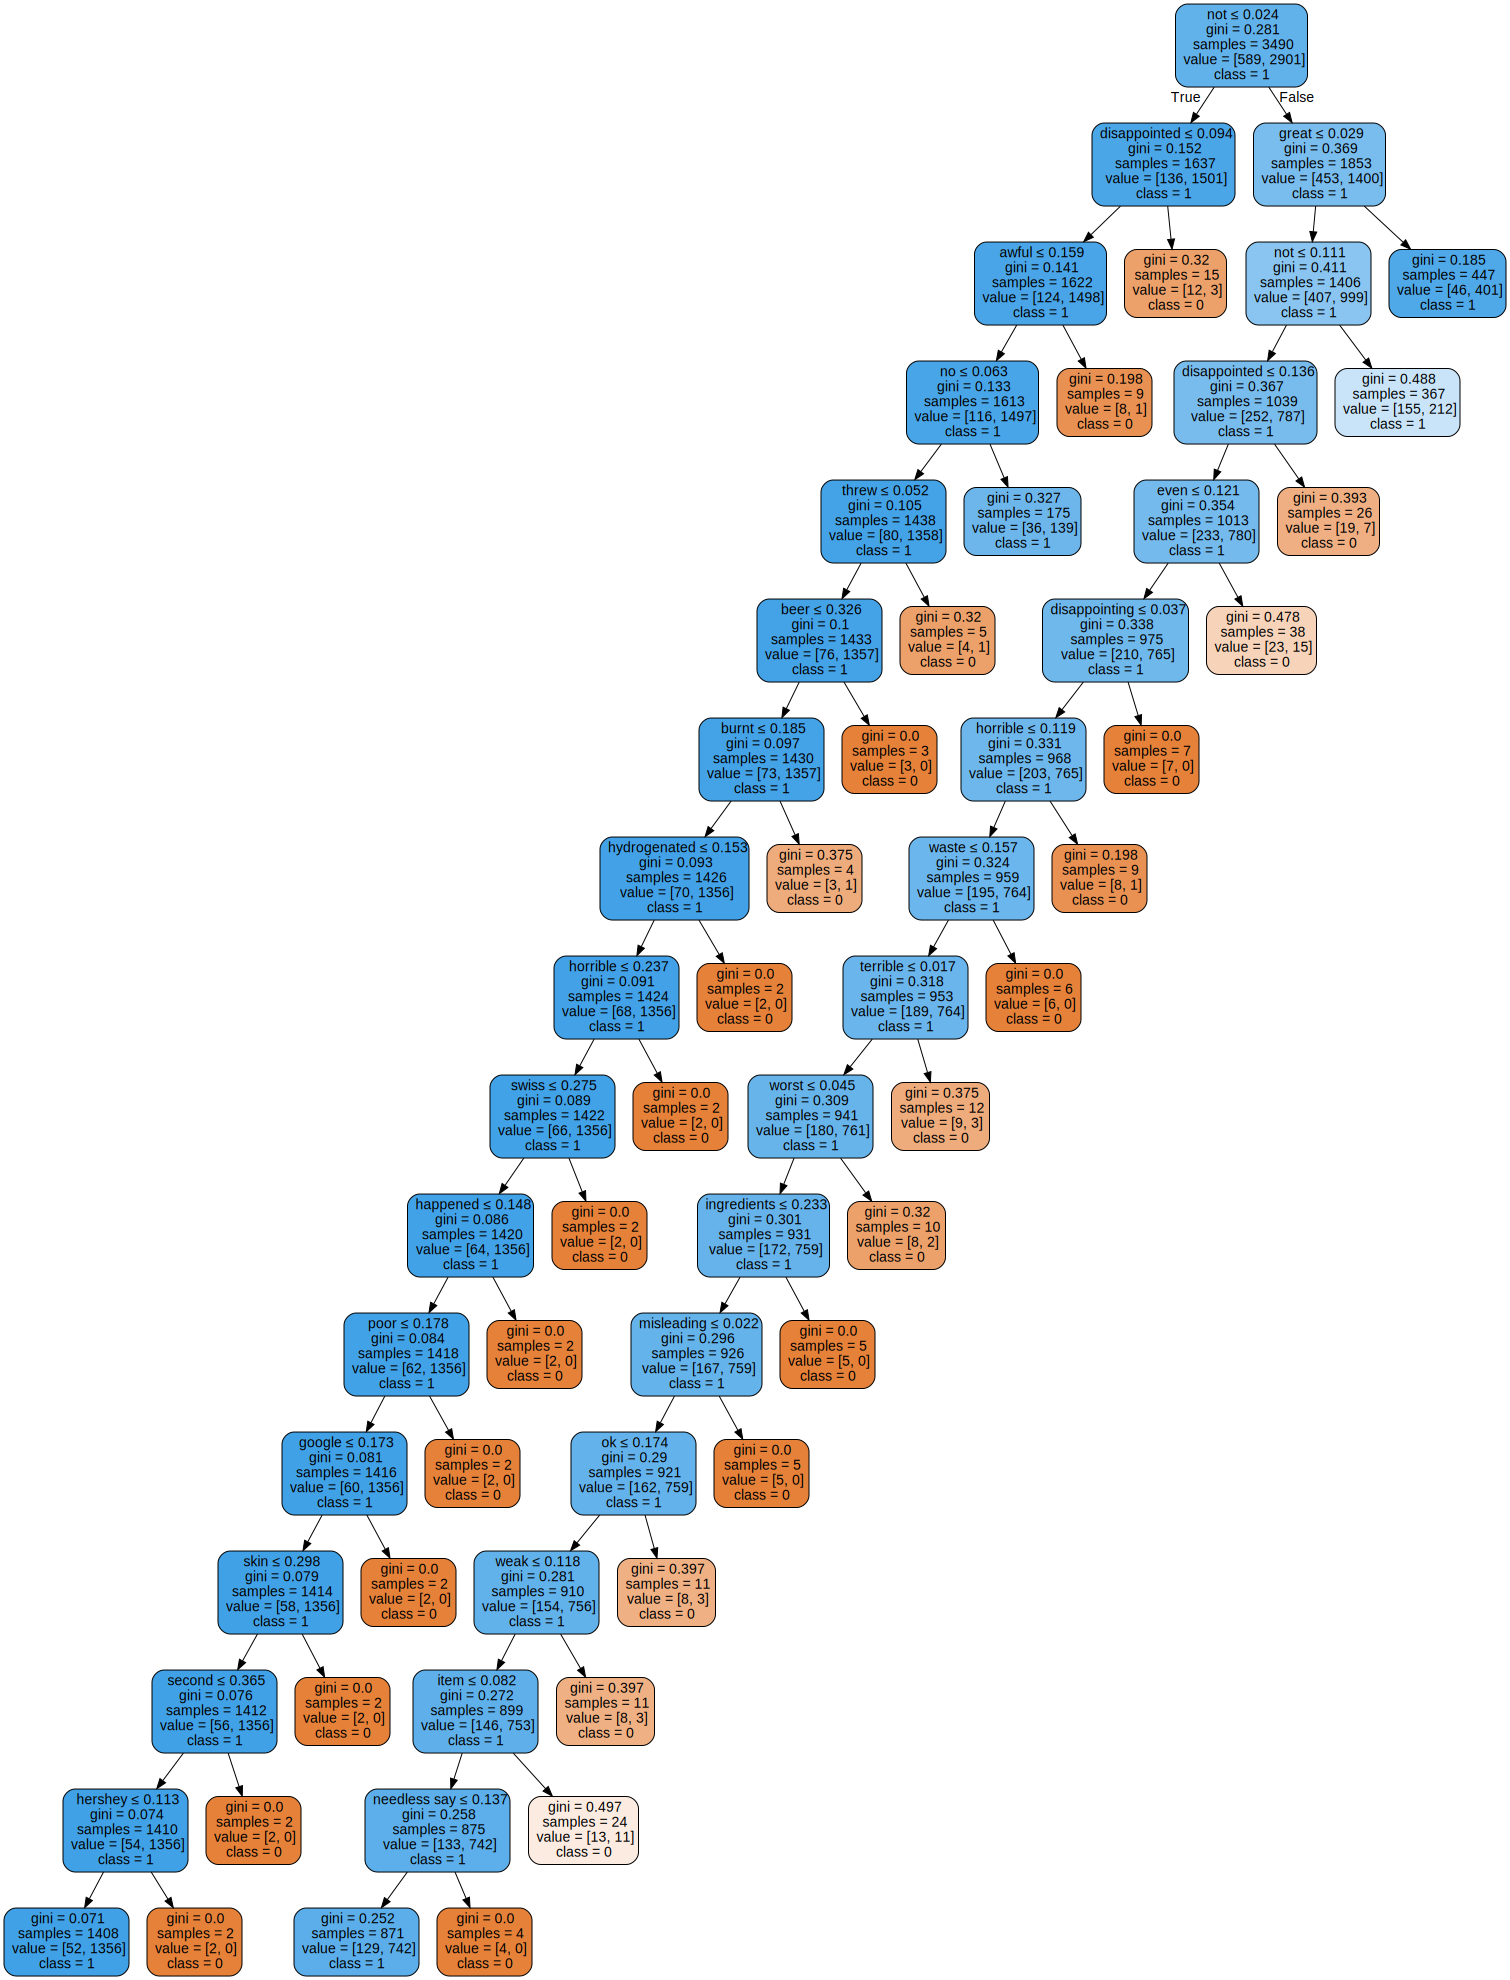

In [12]:
dtreeDOT = tree.export_graphviz(clff2, out_file=None, feature_names=tdidf_vect_features, class_names=['0','1'], filled=True, rounded=True, special_characters=True, max_depth=22)
graph = graphviz.Source(dtreeDOT) 
graph

### Applying Decision Trees on AVG W2V

100%|██████████| 1496/1496 [00:01<00:00, 1338.17it/s]


Optimal Depth for Train Data =  21.0
Optimal Depth for Test Data =  16.0


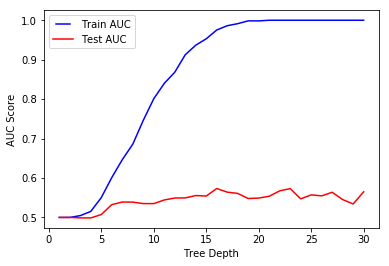

Optimal Minimum Sample Split for Train Data =  0.1
Optimal Minimum Sample Split for Test Data =  0.1


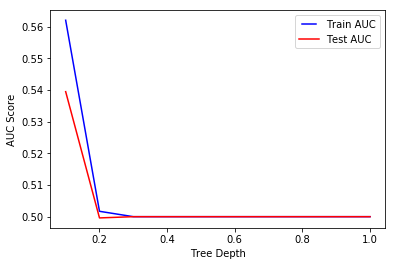

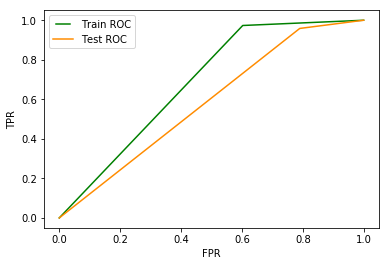

The AUC Score of test data =  0.5842710691081766


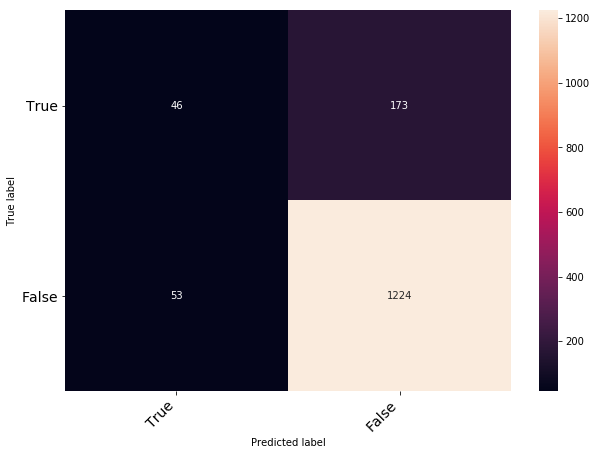

In [13]:
# Please write all the code with proper documentation
# average Word2Vec
i=0
list_of_sentance=[]
list_of_sentance_train=[]
list_of_sentance_test=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


#train test Split of data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

#converting text to vector using Average Word2Vec
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    
sent_vectors_train = []; # the avg-w2v for each sentence/review in train set is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
    
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review in test set is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
#Text to vector conversion completes 


#Fitting the model with default parameters to get the baseline AUC score.    
clf3 = tree.DecisionTreeClassifier()
clf3 = clf3.fit(sent_vectors_train, y_train)
y_pred = clf3.predict(sent_vectors_test)
#Baseline AUC calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


#Finding Optimal Depth For Train and Test Data
max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []

#stores the optimum depth which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalDepthTrain = 0
optimalDepthTest = 0

for max_depth in max_depths:
    clf3 = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf3.fit(sent_vectors_train, y_train)
    train_pred = clf3.predict(sent_vectors_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalDepthTrain = max_depth
    # Add auc score to previous train results
    train_results.append(roc_auc_train)

    y_pred = clf3.predict(sent_vectors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalDepthTest = max_depth
    # Add auc score to previous test results
    test_results.append(roc_auc_test)
    
print("Optimal Depth for Train Data = ",optimalDepthTrain)
print("Optimal Depth for Test Data = ",optimalDepthTest)
#Plots the Train and Test data with Depth
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()


#Finding The Optimal Minimum Samples Split For Train and Test Data
from matplotlib.legend_handler import HandlerLine2D
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

#stores the optimum minSamples Split which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalMinSSplitTrain = 0
optimalMinSSplitTest = 0

for min_samples_split in min_samples_splits:
    clf3 = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
    clf3.fit(sent_vectors_train, y_train)
    train_pred = clf3.predict(sent_vectors_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalMinSSplitTrain = min_samples_split
        
    # Add auc score to previous train results
    train_results.append(roc_auc_train)
    
    y_pred = clf3.predict(sent_vectors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalMinSSplitTest = min_samples_split
    # Add auc score to previous test results
    test_results.append(roc_auc_test)

print("Optimal Minimum Sample Split for Train Data = ",optimalMinSSplitTrain)
print("Optimal Minimum Sample Split for Test Data = ",optimalMinSSplitTest)
#Plots the Train and Test data with Depth
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()


#Finding Model Performance based on optimal parameters found above. We will plot the ROC and show the confusion matrix
#Training with optimal parameters
clff3 = tree.DecisionTreeClassifier(max_depth=optimalDepthTest, min_samples_split=optimalMinSSplitTest)
clff3 = clff3.fit(final_counts_train, y_train)
#Prediction on train and test data
train_pred = clff3.predict(final_counts_train)
y_pred = clff3.predict(final_counts_test)


#ROC for training data
false_positive_rateTr, true_positive_rateTr, thresholdsTr = roc_curve(y_train, train_pred)
#ROC for test data
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Plot ROC for train/test
line1, = plt.plot(false_positive_rateTr, true_positive_rateTr, 'green', label="Train ROC")
line2, = plt.plot(false_positive_rate, true_positive_rate, 'darkorange', label="Test ROC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data = ",roc_auc)
#plotting the confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

### Applying Decision Trees on TFIDF W2V

100%|██████████| 1496/1496 [00:04<00:00, 326.96it/s]


Optimal Depth for Train Data =  29.0
Optimal Depth for Test Data =  25.0


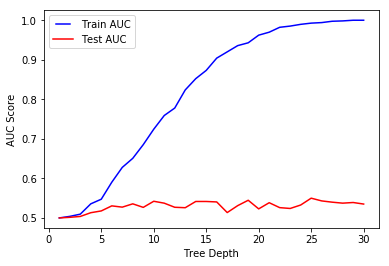

Optimal Minimum Sample Split for Train Data =  0.1
Optimal Minimum Sample Split for Test Data =  0.2


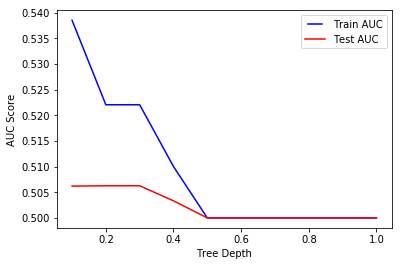

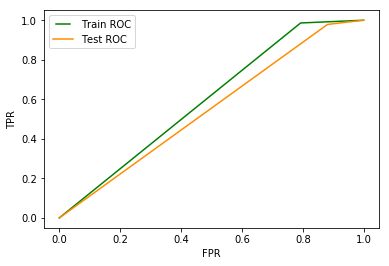

The AUC Score of test data =  0.5487890782835054


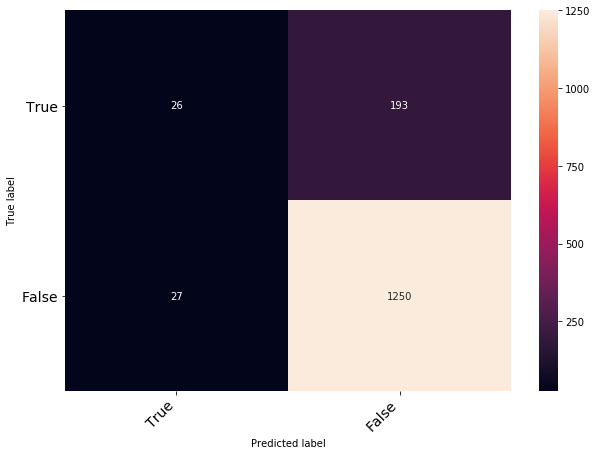

In [14]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)
tfidf_model = TfidfVectorizer()
tfidf_vect_train = tfidf_model.fit_transform(X_train)
tfidf_vect_test = tfidf_model.fit(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names

list_of_sentance_train=[]
list_of_sentance_test=[]

for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
    
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
#text to vector conversion complete using TFIDF-Weighted Word2Vec

#Finding Optimal Depth For Train and Test Data
max_depths = np.linspace(1, 30, 30, endpoint=True)
train_results = []
test_results = []

#stores the optimum depth which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalDepthTrain = 0
optimalDepthTest = 0

for max_depth in max_depths:
    clf3 = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf3.fit(tfidf_sent_vectors_train, y_train)
    train_pred = clf3.predict(tfidf_sent_vectors_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalDepthTrain = max_depth
    # Add auc score to previous train results
    train_results.append(roc_auc_train)

    y_pred = clf3.predict(tfidf_sent_vectors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalDepthTest = max_depth
    # Add auc score to previous test results
    test_results.append(roc_auc_test)
    
print("Optimal Depth for Train Data = ",optimalDepthTrain)
print("Optimal Depth for Test Data = ",optimalDepthTest)
#Plots the Train and Test data with Depth
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()


#Finding The Optimal Minimum Samples Split For Train and Test Data
from matplotlib.legend_handler import HandlerLine2D
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

#stores the optimum minSamples Split which has highest AUC score
max_roc_auc_train = 0
max_roc_auc_test = 0
optimalMinSSplitTrain = 0
optimalMinSSplitTest = 0

for min_samples_split in min_samples_splits:
    clf3 = tree.DecisionTreeClassifier(min_samples_split=min_samples_split)
    clf3.fit(tfidf_sent_vectors_train, y_train)
    train_pred = clf3.predict(tfidf_sent_vectors_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc_train = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_train > max_roc_auc_train:
        max_roc_auc_train = roc_auc_train
        optimalMinSSplitTrain = min_samples_split
        
    # Add auc score to previous train results
    train_results.append(roc_auc_train)
    
    y_pred = clf3.predict(tfidf_sent_vectors_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc_test = auc(false_positive_rate, true_positive_rate)
    
    #store the optimal depth and the corresponding AUC score
    if roc_auc_test > max_roc_auc_test:
        max_roc_auc_test = roc_auc_test
        optimalMinSSplitTest = min_samples_split
    # Add auc score to previous test results
    test_results.append(roc_auc_test)

print("Optimal Minimum Sample Split for Train Data = ",optimalMinSSplitTrain)
print("Optimal Minimum Sample Split for Test Data = ",optimalMinSSplitTest)
#Plots the Train and Test data with Depth
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC Score')
plt.xlabel('Tree Depth')
plt.show()


#Finding Model Performance based on optimal parameters found above. We will plot the ROC and show the confusion matrix
#Training with optimal parameters
clff3 = tree.DecisionTreeClassifier(max_depth=optimalDepthTest, min_samples_split=optimalMinSSplitTest)
clff3 = clff3.fit(final_counts_train, y_train)
#Prediction on train and test data
train_pred = clff3.predict(final_counts_train)
y_pred = clff3.predict(final_counts_test)


#ROC for training data
false_positive_rateTr, true_positive_rateTr, thresholdsTr = roc_curve(y_train, train_pred)
#ROC for test data
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#Plot ROC for train/test
line1, = plt.plot(false_positive_rateTr, true_positive_rateTr, 'green', label="Train ROC")
line2, = plt.plot(false_positive_rate, true_positive_rate, 'darkorange', label="Test ROC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()
#Finding the AUC Score on test data
roc_auc = auc(false_positive_rate, true_positive_rate)
print("The AUC Score of test data = ",roc_auc)
#plotting the confusion matrix
cfs_matrix = confusion_matrix(y_test.values, y_pred)
class_names = ['True', 'False']
print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)

### Results


In [15]:
# Please compare all your models using Prettytable library

# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Hyperparamater: Optimal Max Depth", "Hyperparamater: Optimal Minimal Sample Split", "AUC"]
x.add_row(["BoW",36, 0.1, 0.56])
x.add_row(["TFIDF",28, 0.1, 0.60])
x.add_row(["AVG-W2V",7, 0.1, 0.54])
x.add_row(["TFIDF-Weighted-W2V",25, 0.30, 0.54])
print(x)


+--------------------+-----------------------------------+----------------------------------------------+------+
|     Vectorizer     | Hyperparamater: Optimal Max Depth | Hyperparamater: Optimal Minimal Sample Split | AUC  |
+--------------------+-----------------------------------+----------------------------------------------+------+
|        BoW         |                 36                |                     0.1                      | 0.56 |
|       TFIDF        |                 28                |                     0.1                      | 0.6  |
|      AVG-W2V       |                 7                 |                     0.1                      | 0.54 |
| TFIDF-Weighted-W2V |                 25                |                     0.3                      | 0.54 |
+--------------------+-----------------------------------+----------------------------------------------+------+
